(51, 101)


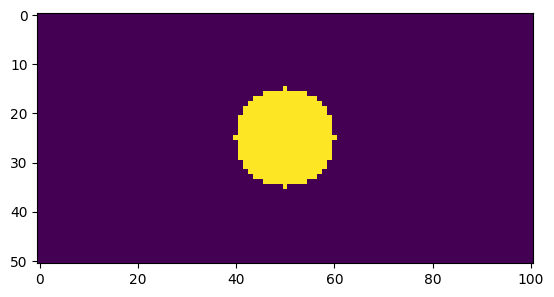

In [8]:
import numpy as np
import matplotlib.pyplot as plt

PARAMS = {
    'Nx': 50,
    'Ny': 100,
    'dx': 0.1,
    'Vc': 10.0,
    'Rc': 1.0,
    'epsilon': 1e-6,
    'omega': 1.0
}

V = np.zeros((PARAMS['Nx']+1, PARAMS['Ny']+1))

# Ustawienie potencjału nanoruki bazując na warunkach brzegowych

# WB Dirichleta w okręgu
ic, jc = (PARAMS['Nx']//2, PARAMS['Ny']//2)
i_coords, j_coords = np.meshgrid(np.arange(PARAMS['Nx'] + 1), np.arange(PARAMS['Ny'] + 1), indexing='ij')

R_grid = PARAMS['Rc'] / PARAMS['dx']
distance_squared = (i_coords - ic)**2 + (j_coords - jc)**2
nanotube_mask = distance_squared <= R_grid**2
V[nanotube_mask] = PARAMS['Vc']

#WB Neumana (Potencjał na granicy równy potencjałowi sąsiedniemu)
def apply_neumann_wb(V_grid):
    global PARAMS

    # Lewa krawędź
    V_grid[0, 1:PARAMS['Ny']] = V_grid[1, 1:PARAMS['Ny']]
    # Prawa krawędź
    V_grid[PARAMS['Nx'], 1:PARAMS['Ny']] = V_grid[PARAMS['Nx'] - 1, 1:PARAMS['Ny']]

    return V_grid

V = apply_neumann_wb(V)


print(V.shape)
plt.imshow(V)
plt.show()